In [1]:
from pyDOE import *
#import sample_generator as sg
import timeit
import numpy as np
import cPickle as pickle
import healpy as hp
import glob
from multiprocessing import Pool,sharedctypes
from functools import partial
from contextlib import closing
import numpy as np

def save_obj(name, obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        mute = pickle.load(f)
        f.close()
    return mute


'''
This notebook trains the emulator. You need to run the blocks pixelfunction and latin hypercube - then,
before running the rest of the notebook, you need to run the c++ code that produces  <d^2>(z) <d^3>(z) as
a function of cosmology (need to run generate_theory_emulator.py)
'''

'\nThis notebook trains the emulator. You need to run the blocks pixelfunction and latin hypercube - then,\nbefore running the rest of the notebook, you need to run the c++ code that produces  <d^2>(z) <d^3>(z) as\na function of cosmology (need to run generate_theory_emulator.py)\n'

# pixelfunction

In [2]:
# it saves the pixel functions needed by the theory code.

_,Cl = hp.sphtfunc.pixwin(1024,pol=True)
aa = open("./theory_code/Cl_pix/CL_pix1_2048_1024.txt","w")
for i in range(1024*2):
    aa.write("{0} \n".format(Cl[i]))
aa.close()
_,Cl = hp.sphtfunc.pixwin(512,pol=True)
aa = open("./theory_code/Cl_pix/CL_pix1_1024_512.txt","w")
for i in range(512*2):
    aa.write("{0} \n".format(Cl[i]))
aa.close()
_,Cl = hp.sphtfunc.pixwin(256,pol=True)
aa = open("./theory_code/Cl_pix/CL_pix1_512_256.txt","w")
for i in range(256*2):
    aa.write("{0} \n".format(Cl[i]))
aa.close()

# Latin hypercube

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

'''
it defines two nested hyper-cubes. The second one is restricted
to the area most important for parameter estimation.
'''


#theano.config.compile.timeout = 1000

def save_obj(name, obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        f.close()
        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        mute =  pickle.load(f)
        f.close()
    return mute


# first hypercube.
omega_m = [0.12,0.9] #Omega_m
omega_b = [0.02,0.09] #Omega_b
sigma_8 = [0.3,1.3] #sigma_8
h0 = [0.6,0.95] #h0
ns = [0.87,1.1] #ns

#second hypercube.
omega_m_0 = [0.15,0.4] #Omega_m
omega_b_0 = [0.02,0.09] #Omega_b
sigma_8_0 = [0.65,0.95] #sigma_8
h0_0 = [0.6,0.95] #h0
ns_0 = [0.87,1.1] #ns

sample_1 = 2500
sample_2 = 500


vv = lhs(5, samples=sample_1, criterion='center')
vv[:,0] = vv[:,0]*(omega_m[1]-omega_m[0])+omega_m[0]
vv[:,1] = vv[:,1]*(omega_b[1]-omega_b[0])+omega_b[0]
vv[:,2] = vv[:,2]*(sigma_8[1]-sigma_8[0])+sigma_8[0]
vv[:,3] = vv[:,3]*(h0[1]-h0[0])+h0[0]
vv[:,4] = vv[:,4]*(ns[1]-ns[0])+ns[0]

vv1 = lhs(5, samples=sample_2, criterion='center')

vv1[:,0] = vv1[:,0]*(omega_m_0[1]-omega_m_0[0])+omega_m_0[0]
vv1[:,1] = vv1[:,1]*(omega_b_0[1]-omega_b_0[0])+omega_b_0[0]
vv1[:,2] = vv1[:,2]*(sigma_8_0[1]-sigma_8_0[0])+sigma_8_0[0]
vv1[:,3] = vv1[:,3]*(h0_0[1]-h0_0[0])+h0_0[0]
vv1[:,4] = vv1[:,4]*(ns_0[1]-ns_0[0])+ns_0[0]


v_final = np.vstack([vv,vv1])

#save_obj("/global/project/projectdirs/des/mgatti/Moments_analysis/emulator_training_points/points_{0}_parameters_5".format(sample_1+sample_2),v_final)

print ('done')

In [3]:
3

3

# Create Emulator + GP

In [6]:
# the first folder contains the runs with only PT activated.
# the second folder contains the runs with PT + small scales fitting formulae.
folder_trains = ['/global/project/projectdirs/des/mgatti/Moments_analysis/EMU_PT/',
                 '/global/project/projectdirs/des/mgatti/Moments_analysis/EMU_sc/']

training= "/global/project/projectdirs/des/mgatti/Moments_analysis/emulator_training_points/points_3000_parameters_5"
training_vector = load_obj(training)

def runit(i,fd,tr):

    if (i!=1363) and(i!=2807) and(i!=1154) and(i!=323) and (i!=696) and (i!=1656) and (i!=2228) and (i!=2254) and (i!=2863) and (i!=2996):
    #if (i!=1612) and (i!=338) and (i!=2254) and (i!=2228) and (i!=1725) and (i!=1062) and (i!=2752):
        sigma_8 = tr[i][2]
        Omega_m = tr[i][0]
        Omega_b = tr[i][1]
        n_s = tr[i][4]
        h_100 = tr[i][3]
        # list of parameters
        uu = ['{0:2.4f}'.format(t) for t in tr[i]]
        # check if the parameter list is in the file names
        mask = (np.array([((uu[0] in f)  & (uu[1] in f) &(uu[2] in f)&(uu[3] in f)&(uu[4] in f) ) for f in params_list_2d]))
        #if 1==1:
        try:
            #with warnings.catch_warnings():
                ff2 = np.loadtxt(np.array(files_2d)[mask][0])
                ff3 = np.loadtxt(np.array(files_3d)[mask][0])
                ff2[290][9]
                ff3[290][9]
                if (not (np.array(ff2).shape[0]>1)) and (not (np.array(ff3).shape[0]>1)):
                    print (i)
                    pass
                return [sigma_8,Omega_m,Omega_b,n_s,h_100,ff2,ff3]
        except:
            print (i)
            pass
        #       
for folder_train in folder_trains:
               
    files_2d = glob.glob(folder_train+'/d2_ME_*')
    files_3d = glob.glob(folder_train+'/d3_ME_*')
    params_list_2d = np.array(['_'.join([('{0:2.4f}'.format(np.float(u))) for u in (files_2d[i].split(folder_train)[1].split('_')[-5:])])
 for i in range(len(files_2d))])
    params_list_3d = np.array(['_'.join([('{0:2.4f}'.format(np.float(u))) for u in (files_3d[i].split(folder_train)[1].split('_')[-5:])])
 for i in range(len(files_3d))])
               
    runs_train = []
    numero_di_runs = len(training_vector)
    agents = 50 #numero di processi
    numero = range(numero_di_runs)
    with closing(Pool(processes=agents)) as pool:
        runs_train.append(pool.map(partial(runit,fd = folder_train,tr=training_vector),numero))


    filet_2_train=[]
    filet_3_train=[]
    sigma_8_train=[]
    Omega_m_train=[]
    Omega_b_train=[]
    n_s_train=[]
    h_100_train=[]

    for i in range(len(training_vector)):
        try:
            #if ((runs_train[0][i][-1].flatten() != runs_train[0][i][-1].flatten() ).any() ) or ((runs_train[0][i][-2].flatten() != runs_train[0][i][-2].flatten() ).any() ):
            #    pass #print ('contains NaN ',i)
            #else:
                sigma_8_train.append(runs_train[0][i][0])
                Omega_m_train.append(runs_train[0][i][1])
                Omega_b_train.append(runs_train[0][i][2])
                n_s_train.append(runs_train[0][i][3])
                h_100_train.append(runs_train[0][i][4])
                filet_2_train.append(runs_train[0][i][-2])
                filet_3_train.append(runs_train[0][i][-1])
        except:
            print ('failed for ',i)

    save_obj(folder_train + "3000_train_c",[sigma_8_train,Omega_m_train,Omega_b_train,n_s_train,h_100_train,filet_2_train,filet_3_train])
print (np.array(filet_3_train).shape)

print ('done')

('failed for ', 323)
('failed for ', 696)
('failed for ', 1154)
('failed for ', 1363)
('failed for ', 1656)
('failed for ', 2228)
('failed for ', 2254)
('failed for ', 2807)
('failed for ', 2863)
('failed for ', 2996)
('failed for ', 323)
('failed for ', 696)
('failed for ', 1154)
('failed for ', 1363)
('failed for ', 1656)
('failed for ', 2228)
('failed for ', 2254)
('failed for ', 2807)
('failed for ', 2863)
('failed for ', 2996)
(2990, 299, 10)
done


# check the training! (optional)

1.0
ConstantKernel(log_constant=-1.60943791243, ndim=5, axes=array([0, 1, 2, 3, 4])) * ExpSquaredKernel(metric=Metric(array([ 0.01,  0.01,  0.01,  0.1 ,  0.01]), ndim=5, axes=array([0, 1, 2, 3, 4]), bounds=[(None, None), (None, None), (None, None), (None, None), (None, None)]), block=None)
(300, 5) (300,)
[-1.60943791 -4.60517019 -4.60517019 -4.60517019 -2.30258509 -4.60517019]
[-1.23083301 -5.18374347 -4.85764141 -6.10805531 -3.51209919 -3.02754603]
0.328852891922


'\n\n[-1.60943791 -6.90775528 -6.90775528 -6.90775528 -6.90775528 -6.90775528]\n[ 0.32206678 -1.94080077 -4.48112682 -5.66149853 -2.27934585 -2.16111062]\n\n'

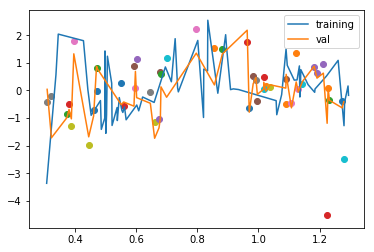

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import george
from george import kernels
import scipy.optimize as op
from scipy.optimize import minimize
i=8

max_training = 300
vald = 200

import timeit
filet_3_train = copy.copy(filet_3_train_new)
start= timeit.default_timer()
sm =2
u,s,v = np.linalg.svd(np.log(filet_3_train[:(max_training+vald),:,sm].T),full_matrices=False)
if 1==1:
            interp =[]
            mean_v = []
            std_v = []
            yy = (v[i][:max_training]-np.mean(v[i][:max_training]))/np.std(v[i][:max_training])
            mean_v.append(np.mean(yy))
            std_v.append(np.std(yy))
            
            def nll(p):
                gp.set_parameter_vector(p)
                ll = gp.log_likelihood(yy, quiet=True)
                return -ll if np.isfinite(ll) else 1e25

            # And the gradient of the objective function.
            def grad_nll(p):
                gp.set_parameter_vector(p)
                return -gp.grad_log_likelihood(yy, quiet=True)

            print np.var(yy )
            kernel = np.var(yy )* kernels.ExpSquaredKernel(np.array([0.01,0.01,0.01,0.1,0.01]), ndim = 5)
            #kernel =kernels.ConstantKernel(-1.60943791243, ndim = 5)
            print kernel
            #ExpSquaredKernel(metric=Metric(array([ 0.5,  0.5,  0.5,  0.5,  0.5]), 
            #ndim=5, axes=array([0, 1, 2, 3, 4]), 
            #bounds=[(None, None), (None, None), (None, None), 
            #(None, None), (None, None)]), block=None)
            
            #ConstantKernel(log_constant=-1.60943791243, ndim=5, axes=array([0, 1, 2, 3, 4])) * ExpSquaredKernel(metric=Metric(array([ 0.5,  0.5,  0.5,  0.5,  0.5]), ndim=5, axes=array([0, 1, 2, 3, 4]), bounds=[(None, None), 
            #(None, None), (None, None), (None, None), (None, None)]), block=None)
            
            gp = george.GP(kernel)
            gp.compute(x_train[:,:max_training].T)
            print (x_train[:,:max_training].T).shape,yy.shape
            #print(gp.log_likelihood(v[i]))

            # Run the optimization routine.
            p0 = gp.get_parameter_vector()
            print p0
            
            results = op.minimize(nll, p0, jac=grad_nll)#, method="L-BFGS-B")

            # Update the kernel and print the final log-likelihood.
            gp.set_parameter_vector(results.x)
            p0 = gp.get_parameter_vector()
            #print(gp.log_likelihood(v[i]))
            #print "done"
            print p0
            interp.append(gp)

end = timeit.default_timer()
print end-start

dimm = 0
x0 = x_train.T[:max_training,dimm]
x0_m = x_train.T[:max_training,3]
mask_x0 = (x0_m<1.0) & (x0_m>0.95)
yy_other = (v[i][max_training:]-np.mean(v[i][max_training:]))/np.std(v[i][max_training:])

plt.plot(np.sort(x0[mask_x0]),yy[mask_x0][np.argsort(x0[mask_x0])],label="training")

for ii in range(vald):
    if (x_train.T[max_training+ii,3]<1.0) & (x_train.T[max_training+ii,3]>0.95):
        plt.scatter(x_train.T[max_training+ii,dimm],gp.predict(yy, [x_train.T[max_training+ii,:]])[0])
        #print x_train.T[max_training+ii,0],gp.predict(yy, [x_train.T[max_training+ii,:]])[0]
        


x0 = x_train.T[max_training:(max_training+vald),dimm]
x0_m = x_train.T[max_training:(max_training+vald),3]
mask_x0 = (x0_m<1.0) & (x0_m>0.95)
yy_other = (v[i][max_training:(max_training+vald)]-np.mean(v[i][max_training:(max_training+vald)]))/np.std(v[i][max_training:(max_training+vald)])

plt.plot(np.sort(x0[mask_x0]),yy_other[mask_x0][np.argsort(x0[mask_x0])], label ="val")
plt.legend()
"""

[-1.60943791 -6.90775528 -6.90775528 -6.90775528 -6.90775528 -6.90775528]
[ 0.32206678 -1.94080077 -4.48112682 -5.66149853 -2.27934585 -2.16111062]

"""

# Training

In [4]:
'''
The emulator emulates three different things:
<d^2>,  <d^3>_PT, and <d^3>_(PT+fit)/<d^3>_PT
'''
# point for training.
max_training=500

# principal components *******
svd_2d = 15     
svd_3d = 15
svd_complex = 30

#
agents=20

folder_trains_PT = '/global/project/projectdirs/des/mgatti/Moments_analysis/EMU_PT/'
folder_trains_PTfit = '/global/project/projectdirs/des/mgatti/Moments_analysis/EMU_sc/'
emulator_path_output = '/global/project/projectdirs/des/mgatti/Moments_analysis/emu_sc'



# load training points & dd ddd *************
_,_,_,_,_, filet_2_train_PT, filet_3_train_PT = load_obj(folder_trains_PT + "3000_train_c")
sigma_8_train,Omega_m_train,Omega_b_train,n_s_train,h_100_train, filet_2_train_PTfit, filet_3_train_PTfit = load_obj(folder_trains_PTfit + "3000_train_c")
filet3_comp = copy.copy(np.array(filet_3_train_PTfit)/np.array(filet_3_train_PT))

filet_2_train_PT = np.array(filet_2_train_PT)
filet_3_train_PT = np.array(filet_3_train_PT)
filet_2_train_PTfit = np.array(filet_2_train_PTfit)
filet_3_train_PTfit = np.array(filet_3_train_PTfit)
sigma_8_train = np.array(sigma_8_train)
Omega_m_train = np.array(Omega_m_train)
Omega_b_train = np.array(Omega_b_train)
n_s_train = np.array(n_s_train)
h_100_train = np.array(h_100_train)


# remove NaN
mask = []
for i in range(np.array(filet_3_train_PT).shape[0]):
    if ((filet3_comp.flatten() <0.).any()) and (filet_3_train_PT[i].flatten() != filet_3_train_PT[i].flatten()).any() or (filet_3_train_PTfit[i].flatten() != filet_3_train_PTfit[i].flatten()).any():
        mask.append(i)
mask = np.array(np.in1d(np.arange(0,np.array(filet_3_train_PT).shape[0]),mask))

sigma_8_train = sigma_8_train[~mask]
Omega_m_train = Omega_m_train[~mask]
Omega_b_train = Omega_b_train[~mask]
n_s_train = n_s_train[~mask]
h_100_train = h_100_train[~mask]
filet_3_train_PT  = filet_3_train_PT[~mask]
filet_2_train_PT  = filet_2_train_PT[~mask]
filet_3_train_PTfit  = filet_3_train_PTfit[~mask]
filet_2_train_PTfit  = filet_2_train_PTfit[~mask]
filet3_comp = filet3_comp[~mask]


xt = np.array([sigma_8_train,Omega_m_train,Omega_b_train,n_s_train,h_100_train])


res2 = []
res3 = []
res3c = []
res2_train = []
res3_train = []
res3c_train = []

svd_train = dict()
svd_val = dict()

ang_min = 0
ang_max = filet_3_train_PT.shape[2]
start = timeit.default_timer()


/global/u2/m/mgatti/.conda/envs/myenv/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less


In [ ]:
import george
from george import kernels
import timeit
import scipy.optimize as op
from scipy.optimize import minimize
import copy

def parallel_training(i):
    def nll(p):
        gp.set_parameter_vector(p)
        ll = gp.log_likelihood(yy, quiet=True)
        return -ll if np.isfinite(ll) else 1e2
    # And the gradient of the objective function.
    def grad_nll(p):
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(yy, quiet=True)
              
    # normalise it
    yy = (v[i]-np.mean(v[i]))/np.std(v[i])
    meana= np.mean(yy)
    stda = np.std(yy)

    kernel = np.var(yy) * kernels.ExpSquaredKernel(3*np.array([0.01,0.01,0.01,0.01,0.01]), ndim = 5)

    #kernel = np.var(yy) * kernels.ExpSquaredKernel(np.array([0.01,0.01,0.01,0.001,0.01]), ndim = 5)
    gp = george.GP(kernel)
    gp.compute(xt[:,:max_training].T)
    
    # Run the optimization routine.
    p0 = gp.get_parameter_vector()
    results = op.minimize(nll, p0, jac=grad_nll)#, method="L-BFGS-B"
    # Update the kernel and print the final log-likelihood.
    gp.set_parameter_vector(results.x)
    p0 = gp.get_parameter_vector()    

    if gp.predict(yy, [xt.T[max_training-3,:]])[1]==1:
        print ("2nd failure! ", sm, " " ,i)
    return [meana,stda,gp]


for sm in range(ang_min,ang_max):
    print (sm)
    # FULL
    u,s,v = np.linalg.svd(np.log(filet_2_train_PT[:max_training,:,sm].T),full_matrices=False)
    interp_v = []

    mean_v = []
    std_v = []
    numero =  range(svd_2d)

    runs_val = []
    with closing(Pool(processes=agents)) as pool:
        runs_val.append(pool.map(partial(parallel_training),numero))

    for i in (numero):
        mean_v.append(runs_val[0][i][0])
        std_v.append(runs_val[0][i][1])
        interp_v.append(runs_val[0][i][2])
    svd_2d_matrix = [u,s,v,np.array(mean_v),np.array(std_v),interp_v] 


    m0 = np.dot(u * s, v)
    s1 = copy.copy(s)
    s1[svd_2d:]=0.     
    m1 = np.dot(u * s1, v)
    for jj in range(m0.shape[1]):
        y = m0[:,jj]
        y1 = m1[:,jj]
        res2.append(max(np.sqrt(((np.exp(y1)-np.exp(y))/np.exp(y))**2.)))


    #********************************************************************
    u,s,v = np.linalg.svd(np.log(filet_3_train_PT[:max_training,:,sm].T),full_matrices=False)
    interp_v = []

    mean_v = []
    std_v = []
    numero =  range(svd_3d)

    runs_val = []
    with closing(Pool(processes=agents)) as pool:
        runs_val.append(pool.map(partial(parallel_training),numero))

    for i in (numero):
        mean_v.append(runs_val[0][i][0])
        std_v.append(runs_val[0][i][1])
        interp_v.append(runs_val[0][i][2])
    svd_3d_matrix = [u,s,v,np.array(mean_v),np.array(std_v),interp_v] 

    m0 = np.dot(u * s, v)
    s1 = copy.copy(s)
    s1[svd_3d:]=0.     
    m1 = np.dot(u * s1, v)
    for jj in range(m0.shape[1]):
        y = m0[:,jj]
        y1 = m1[:,jj]
        #plt.plot((y1-y)/y)
        res3.append(max(np.sqrt(((np.exp(y1)-np.exp(y))/np.exp(y))**2.)))




    #********************************************************************
    u,s,v = np.linalg.svd(np.log(filet3_comp[:max_training,:,sm].T),full_matrices=False)
    interp_v = []

    mean_v = []
    std_v = []
    numero =  range(svd_complex)

    runs_val = []
    with closing(Pool(processes=agents)) as pool:
        runs_val.append(pool.map(partial(parallel_training),numero))

    for i in (numero):
        mean_v.append(runs_val[0][i][0])
        std_v.append(runs_val[0][i][1])
        interp_v.append(runs_val[0][i][2])
    svd_3dc_matrix = [u,s,v,np.array(mean_v),np.array(std_v),interp_v] 

    m0 = np.dot(u * s, v)
    s1 = copy.copy(s)
    s1[svd_complex:]=0.     
    m1 = np.dot(u * s1, v)
    for jj in range(m0.shape[1]):
        y = m0[:,jj]
        y1 = m1[:,jj]
        res3c.append(max(np.sqrt(((np.exp(y1)-np.exp(y))/np.exp(y))**2.)))
    svd_train.update({sm:[svd_2d_matrix,res2,svd_3d_matrix,res3,svd_3dc_matrix,res3c]})

    
print ("done")
end = timeit.default_timer()
max_res = []
for sm in range(ang_min,ang_max):
    max_res .append(np.mean(svd_train[sm][1]))
print( "max res2: " ,np.mean(np.array(max_res)))
max_res = []
for sm in range(ang_min,ang_max):
    max_res.append(np.mean(svd_train[sm][3]))
print( "max res3: " ,np.mean(np.array(max_res)))
max_res = []
for sm in range(ang_min,ang_max):
    max_res.append(np.mean(svd_train[sm][5]))
print ("max res3c: " ,np.mean(np.array(max_res)))

print ("time needed: ",end-start)
save_obj(emulator_path_output,svd_train)
save_obj(emulator_path_output+'_checks',[sigma_8_train,Omega_m_train,Omega_b_train,n_s_train,h_100_train,filet_2_train_PT, filet_3_train_PT,filet3_comp,filet_3_train_sPTfit])







0


In [1]:
3

3

done!


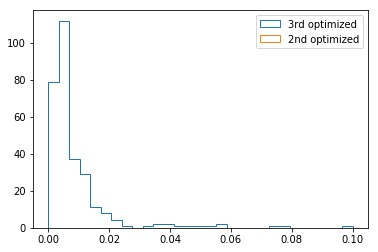

In [155]:
# VALIDATION **********************************************************************************************************************************************************************************************************************************************


gps = [emulator_path_output]#,'/global/cscratch1/sd/mgatti/Mass_Mapping/emulator/500_svd_GP_1024']
svds = [emulator_path_output+'_checks']#,"/global/cscratch1/sd/mgatti/Mass_Mapping/emulator/3000_1024_train_c"]

#000_1024_gm_train_c
gps_err =dict()
for xxx,gp in enumerate(gps):
    svd_train = load_obj(gp)
    sigma_8_train,Omega_m_train,Omega_b_train,n_s_train,h_100_train,filet_2_train,filet_3_train_old,filet_3_train_comp,filet_3_train = load_obj(svds[xxx])

    mute_dict = dict()
    def compute(input_cosmology):
        d2_array = []
        d3_array = []
        d3_arrayc = []

        for sm in range(filet_2_train.shape[2]):
            if ((sm>=ang_min) & (sm<ang_max)):
                dim = len(svd_train[sm][0][-1])
                v0 = []
                for i in range(dim):
                    YY_std = svd_train[sm][0][4][i]
                    YY_mean = svd_train[sm][0][3][i]
                    YY_in = (svd_train[sm][0][2][i]-YY_mean)/YY_std
                    v0.append((svd_train[sm][0][-1][i].predict(YY_in, input_cosmology)[0])*YY_std+YY_mean)
                v0 = np.array(v0).reshape(dim)
                d2_array.append(np.exp(np.array(np.dot(svd_train[sm][0][0][:,:dim] * svd_train[sm][0][1][:dim], v0))))


                dim = len(svd_train[sm][2][-1])
                v0 = []
                for i in range(dim):
                    YY_std = svd_train[sm][2][4][i]
                    YY_mean = svd_train[sm][2][3][i]
                    YY_in = (svd_train[sm][2][2][i]-YY_mean)/YY_std
                    v0.append((svd_train[sm][2][-1][i].predict(YY_in, input_cosmology)[0])*YY_std+YY_mean)
                v0 = np.array(v0).reshape(dim)
                d3_array.append(np.exp(np.dot(svd_train[sm][2][0][:,:dim] * svd_train[sm][2][1][:dim], v0)))

                
                dim = len(svd_train[sm][4][-1])
                v0 = []
                for i in range(dim):
                    YY_std = svd_train[sm][4][4][i]
                    YY_mean = svd_train[sm][4][3][i]
                    YY_in = (svd_train[sm][4][2][i]-YY_mean)/YY_std
                    v0.append((svd_train[sm][4][-1][i].predict(YY_in, input_cosmology)[0])*YY_std+YY_mean)
                v0 = np.array(v0).reshape(dim)
                d3_arrayc.append(np.exp(np.dot(svd_train[sm][4][0][:,:dim] * svd_train[sm][4][1][:dim], v0)))
             
            else:
                d2_array.append(np.zeros(181))
                d3_array.append(np.zeros(181))
                d3_arrayc.append(np.zeros(181))
        end = timeit.default_timer()
        d2_array = np.array(d2_array)
        d3_array = np.array(d3_array)*np.array(d3_arrayc)
        return d2_array,d3_array




    
    svd_info = load_obj(svds[xxx])
    filet_2_train = svd_info[-4]
    filet_3_train = svd_info[-1]

    x_train = np.array([svd_info[0],svd_info[1],svd_info[2],svd_info[3],svd_info[4]])


    ft2 = filet_2_train[1500:1800,:,:]
    ft3 = filet_3_train[1500:1800,:,:]
    xv = x_train[:,1500:1800]

    #ft2 = filet_2_train[:100,:,:]
    #ft3 = filet_3_train[:100,:,:]
    #xv = x_train[:,:100]
    
    err_val = np.zeros((xv.shape[1],ft2.shape[2]))
    err_val_3rd = np.zeros((xv.shape[1],ft2.shape[2]))

    err_val1 = np.zeros((xv.shape[1]))
    err_val1_3rd = np.zeros((xv.shape[1]))



    start = timeit.default_timer()
    for i in range(xv.shape[1]):

        input_cosmology = np.array([xv[:,i]])
        dd2,dd3 = compute(input_cosmology)


        for kk in range(ft2.shape[2]):
            err_val[i,kk] = np.mean(np.abs((dd2[ang_min:ang_max,kk]-ft2[i].T[ang_min:ang_max,kk])/ft2[i].T[ang_min:ang_max,kk]))
        err_val1[i]=np.mean(err_val[i,:])

        for kk in range(ft2.shape[2]):
            err_val_3rd[i,kk] = np.mean(np.abs((dd3[ang_min:ang_max,kk]-ft3[i].T[ang_min:ang_max,kk])/ft3[i].T[ang_min:ang_max,kk]))
        err_val1_3rd[i]=np.mean(err_val_3rd[i,:])
    end = timeit.default_timer()
    mute_dict['time'] =(end-start)/300
    mute_dict['err_val1'] =err_val1
    mute_dict['err_val1_3rd'] =err_val1_3rd
    mute_dict['err_val'] =err_val
    mute_dict['err_val_3rd'] =err_val_3rd
    gps_err.update({gp:mute_dict})
    plt.hist(err_val1_3rd,histtype="step",bins = np.linspace(0.,0.1,30), label = "3rd optimized")
    plt.hist(err_val1,histtype="step",bins = np.linspace(0.,0.1,30), label = "2nd optimized")
    plt.legend()
    plt.show()


# Validation

/global/cscratch1/sd/mgatti/Mass_Mapping/emulator/500_svd_GP_1024_gm
done!


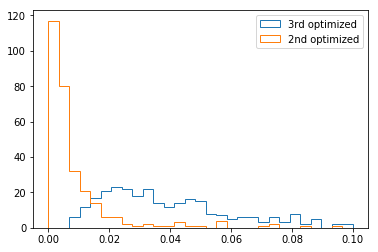

In [8]:

%matplotlib inline
import matplotlib.pyplot as plt
import george
from george import kernels
import scipy.optimize as op
from scipy.optimize import minimize

path_gps = '/global/cscratch1/sd/mgatti/Mass_Mapping/emulator/'
gps = [path_gps+'500_svd_GP_256',path_gps+'500_svd_GP_512',path_gps+'500_svd_GP_1024']#,'/global/cscratch1/sd/mgatti/Mass_Mapping/emulator/500_svd_GP_1024']
svds = [path_gps+'3000_256_train_c',path_gps+'3000_512_train_c',path_gps+'3000_1024_train_c']#,"/global/cscratch1/sd/mgatti/Mass_Mapping/emulator/3000_1024_train_c"]
gps = [path_gps+'500_svd_GP_1024_gm']#,'/global/cscratch1/sd/mgatti/Mass_Mapping/emulator/500_svd_GP_1024']
svds = [path_gps+'3000_1024_gm_train_c']#,"/global/cscratch1/sd/mgatti/Mass_Mapping/emulator/3000_1024_train_c"]

#000_1024_gm_train_c
gps_err =dict()
for xxx,gp in enumerate(gps):
    print gp
    sigma_8_train,Omega_m_train,Omega_b_train,n_s_train,h_100_train,filet_2_train,filet_3_train = load_obj(svds[xxx])

    mute_dict = dict()
    def compute(input_cosmology):
        d2_array = []
        d3_array = []

        for sm in range(filet_2_train.shape[2]):
                dim = len(svd_train[sm][0][-1])
                v0 = []
                for i in range(dim):
                    YY_std = svd_train[sm][0][4][i]
                    YY_mean = svd_train[sm][0][3][i]
                    YY_in = (svd_train[sm][0][2][i]-YY_mean)/YY_std
                    v0.append((svd_train[sm][0][-1][i].predict(YY_in, input_cosmology)[0])*YY_std+YY_mean)
                v0 = np.array(v0).reshape(dim)
                d2_array.append(np.exp(np.array(np.dot(svd_train[sm][0][0][:,:dim] * svd_train[sm][0][1][:dim], v0))))


                dim = len(svd_train[sm][2][-1])
                v0 = []
                for i in range(dim):
                    YY_std = svd_train[sm][2][4][i]
                    YY_mean = svd_train[sm][2][3][i]
                    YY_in = (svd_train[sm][2][2][i]-YY_mean)/YY_std
                    v0.append((svd_train[sm][2][-1][i].predict(YY_in, input_cosmology)[0])*YY_std+YY_mean)
                v0 = np.array(v0).reshape(dim)
                d3_array.append(np.exp(np.dot(svd_train[sm][2][0][:,:dim] * svd_train[sm][2][1][:dim], v0)))
        end = timeit.default_timer()
        d2_array = np.array(d2_array)
        d3_array = np.array(d3_array)
        return d2_array,d3_array




    svd_train = load_obj(gp)
    svd_info = load_obj(svds[xxx])
    filet_2_train = svd_info[-2]
    filet_3_train = svd_info[-1]

    x_train = np.array([svd_info[0],svd_info[1],svd_info[2],svd_info[3],svd_info[4]])


    ft2 = filet_2_train[1500:1800,:,:]
    ft3 = filet_3_train[1500:1800,:,:]
    xv = x_train[:,1500:1800]

    #ft2 = filet_2_train[:100,:,:]
    #ft3 = filet_3_train[:100,:,:]
    #xv = x_train[:,:100]
    
    err_val = np.zeros((xv.shape[1],ft2.shape[2]))
    err_val_3rd = np.zeros((xv.shape[1],ft2.shape[2]))

    err_val1 = np.zeros((xv.shape[1]))
    err_val1_3rd = np.zeros((xv.shape[1]))



    start = timeit.default_timer()
    for i in range(xv.shape[1]):

        input_cosmology = np.array([xv[:,i]])
        dd2,dd3 = compute(input_cosmology)


        for kk in range(ft2.shape[2]):
            err_val[i,kk] = max(np.abs((dd2[:,kk]-ft2[i].T[:,kk])/ft2[i].T[:,kk]))
        err_val1[i]=max(err_val[i,:])

        for kk in range(ft2.shape[2]):
            err_val_3rd[i,kk] = max(np.abs((dd3[:,kk]-ft3[i].T[:,kk])/ft3[i].T[:,kk]))
        err_val1_3rd[i]=max(err_val_3rd[i,:])
    end = timeit.default_timer()
    print "done!"
    mute_dict['time'] =(end-start)/300
    mute_dict['err_val1'] =err_val1
    mute_dict['err_val1_3rd'] =err_val1_3rd
    mute_dict['err_val'] =err_val
    mute_dict['err_val_3rd'] =err_val_3rd
    gps_err.update({gp:mute_dict})
    plt.hist(err_val1_3rd,histtype="step",bins = np.linspace(0.,0.1,30), label = "3rd optimized")
    plt.hist(err_val1,histtype="step",bins = np.linspace(0.,0.1,30), label = "2nd optimized")
    plt.legend()
    plt.show()

120

0.138889603619
0.519712280051


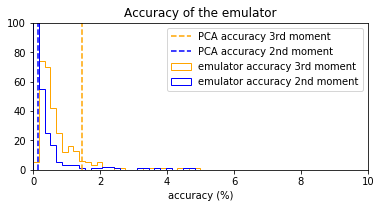

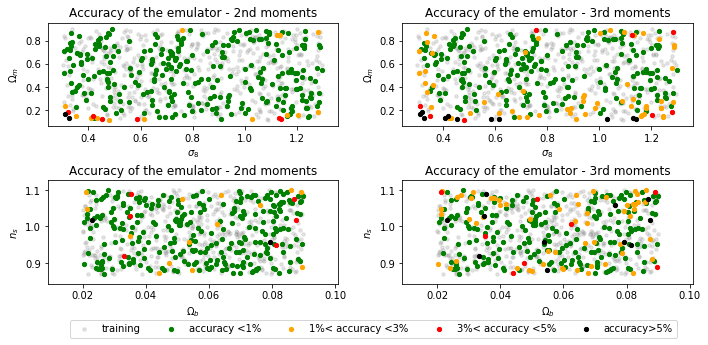

In [161]:
num = [500]
path_gps = '/global/cscratch1/sd/mgatti/Mass_Mapping/emulator/'
gps = [path_gps+'500_svd_GP_256',path_gps+'500_svd_GP_512',path_gps+'500_svd_GP_1024']#,'/global/cscratch1/sd/mgatti/Mass_Mapping/emulator/500_svd_GP_1024']
svds = [path_gps+'3000_256_train_c',path_gps+'3000_512_train_c',path_gps+'3000_1024_train_c']#,"/global/cscratch1/sd/mgatti/Mass_Mapping/emulator/3000_1024_train_c"]

gps = [path_gps+'500_svd_GP_1024_gm']#,'/global/cscratch1/sd/mgatti/Mass_Mapping/emulator/500_svd_GP_1024']
svds = [path_gps+'3000_1024_gm_train_c']#,"/global/cscratch1/sd/mgatti/Mass_Mapping/emulator/3000_1024_train_c"]

labels = [1024]


res2 = 0.00144318979313*100
res3 = 0.014468485428*100


for mm,gp in enumerate(gps):
    label = labels[mm]
    svd_info = load_obj(svds[xxx])
    filet_2_train = svd_info[-2]
    filet_3_train = svd_info[-1]

    x_train = np.array([svd_info[0],svd_info[1],svd_info[2],svd_info[3],svd_info[4]])


    ft2 = filet_2_train[1500:1800,:,:]
    ft3 = filet_3_train[1500:1800,:,:]
    xv = x_train[:,1500:1800]
    
    
    fig, ax = plt.subplots(1,1,sharex=True, sharey=True, figsize=(6,3))
    plt.title("Accuracy of the emulator")
    print np.median(gps_err[gp]['err_val1']*100)
    print np.median(gps_err[gp]['err_val1_3rd']*100)
    plt.hist(gps_err[gp]['err_val1_3rd']*100,histtype="step",bins = np.linspace(0.,5,30), label = "emulator accuracy 3rd moment",color="orange")
    plt.hist(gps_err[gp]['err_val1']*100,histtype="step",bins = np.linspace(0.,5,30), label = "emulator accuracy 2nd moment",color="blue")
    plt.plot([res3,res3],[0,100],color='orange', linestyle="dashed",label ="PCA accuracy 3rd moment")
    plt.plot([res2,res2],[0,100],color="blue", linestyle="dashed",label ="PCA accuracy 2nd moment")
    
    ax.set_ylim([0,100])
    ax.set_xlim([0,10])
    plt
    plt.xlabel("accuracy (%)")
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.legend()
    plt.savefig("Accuracy_emulator_{0}.png".format(label))
    #plt.show()
    

    labels = [r"$\sigma_8$",r"$\Omega_m$",r"$\Omega_b$",r"$n_s$",r"$h_{100}$"]


    xt = x_train[:,:num[mm]]
    xv = x_train[:,1500:1800]

    fig, ax = plt.subplots(2,2,sharex=False, sharey=False, figsize=(10,5))
    
    for h in range(2):
        p1=2*h
        p2=2*h+1
        err = gps_err[gp]['err_val1']#[:max_training]
        ax[h,0].set_title("Accuracy of the emulator - 2nd moments")
        ax[h,0].scatter(xt[p1,:],xt[p2,:],s=600*0.02,label ="training",color='gray',alpha=0.2)
        mask =err <0.01
        ax[h,0].scatter(xv[p1,mask],xv[p2,mask],s = 600*0.03, label ="val. (accuracy <1%)",color='green')
        mask =(err>0.01) & (err <0.03)

        ax[h,0].scatter(xv[p1,mask],xv[p2,mask],s = 600*0.03, label ="val. (1%< accuracy <3%)",color='orange')
        mask =(err>0.03) & (err <0.05)

        ax[h,0].scatter(xv[p1,mask],xv[p2,mask],s = 600*0.03, label ="val. ( 3%< accuracy <5%)",color='red')
        mask =(err>0.05)

        ax[h,0].scatter(xv[p1,mask],xv[p2,mask],s = 600*0.03, label ="val. (  accuracy>5%)",color='black')

        ax[h,0].set_xlabel(labels[p1])
        ax[h,0].set_ylabel(labels[p2])


        ax[h,1].set_title("Accuracy of the emulator - 3rd moments")
        err = gps_err[gp]['err_val1_3rd']#[:max_training]
        ax[h,1].scatter(xt[p1,:],xt[p2,:],s=600*0.02,label ="training",color='gray',alpha=0.2)
        mask =err <0.01
        ax[h,1].scatter(xv[p1,mask],xv[p2,mask],s = 600*0.03, label ="accuracy <1%",color='green')
        mask =(err>0.01) & (err <0.03)

        ax[h,1].scatter(xv[p1,mask],xv[p2,mask],s = 600*0.03, label ="1%< accuracy <3%",color='orange')
        mask =(err>0.03) & (err <0.05)

        ax[h,1].scatter(xv[p1,mask],xv[p2,mask],s = 600*0.03, label ="3%< accuracy <5%",color='red')
        mask =(err>0.05)

        ax[h,1].scatter(xv[p1,mask],xv[p2,mask],s = 600*0.03, label ="accuracy>5%",color='black')

        ax[h,1].set_xlabel(labels[p1])
        ax[h,1].set_ylabel(labels[p2])
        
        
    ax[1,1].legend(loc='upper center', bbox_to_anchor=(-0.1, -0.3),ncol=5)

    
    plt.tight_layout()
    plt.gcf().subplots_adjust(bottom=0.2)

    #plt.show()
    plt.savefig("Accuracy2D_emulator_{0}.png".format(label))